# Hidden Markov Models

Hidden Markov Models (HMMs) are a class of probabilistic graphical model that allow us to predict a sequence of unknown (hidden) variables from a set of observed variables. 

An HMM is characterised by the following:

 - $X$ - states in the model
 - $y$ - the observations
 - $A = \{a_{ij}\}$ - the state transition probabilities
 - $B = \{b_j (k)\}$ - the observation probabilities
 - $\pi$ - the initial state probabilities
    
 

The following figure shows a diagram of the probabilistic parameters of an HMM.
<img src='img/hmm_diagram.png' width='500'/>

There are three fundamental problems regarding HMMs:

- **Problem 1 (Likelihood)**: given an HMM $\lambda = (A,B)$ and an observation sequence O, determine the likelihood $P(O|\lambda)$}.  
- **Problem 2 (Decoding)**: given an HMM $\lambda = (A,B)$ and an observation sequence O, discover the best hidden state sequence.
- **Problem 3 (Learning)**: given an observation sequence O and the set of states in the HMM, learn the HMM parameters A and B.

*Reference: https://en.wikipedia.org/wiki/Hidden_Markov_model*

Based on the type of the observations, we can differentiate between HMMs with discrete observations, HMMs with continuous observations or a combination of the two. Our implementation can deal with multinomial and Gaussian observations. 

In the followings we provide examples for each type, with explanations on how to use the code in each case. 

In [4]:
#!pip install pyhhmm

In [2]:
#fixing the seaboarn error

import matplotlib.pyplot as plt

# Save the original style.use function.
_original_style_use = plt.style.use

def patched_style_use(style, *args, **kwargs):
    # If the code asks for 'seaborn-ticks', redirect to the available 'seaborn-v0_8-ticks'
    if style == 'seaborn-ticks':
        style = 'seaborn-v0_8-ticks'
    return _original_style_use(style, *args, **kwargs)

# Patch the function
plt.style.use = patched_style_use


In [4]:
import numpy as np
import pickle

from pyhhmm.gaussian import GaussianHMM
from pyhhmm.multinomial import MultinomialHMM
from pyhhmm.heterogeneous import HeterogeneousHMM
import pyhhmm.utils as hu

%load_ext autoreload
%autoreload 2

# Multinomial HMM

Consider the following example from the [Hidden Markov Models](https://web.stanford.edu/~jurafsky/slp3/A.pdf) chapter of **Speech and Language Processing** by Daniel Jurafsky & James H. Martin. All the illustrative images are taken from that source.

A climatologist in 2799 is studying the history of global warming. He cannot find any weather records from Baltimore, Maryland, for summer 2020, but he finds Jason's diary, where it's listed how many ice creams he ate each day of that summer. The goal is to estimate whether it was a hot or cold day based on these observations. The following figure shows a possible HMM representation of this problem.

<img src='img/discrete.png' width='600'/>

The two hidden states (H and C) correspond to hot and cold weather, and the observations O = {1,2,3} correspond to the number of ice creams eaten by Jason on a given day. 

## Setting up the model

The MultinomialHMM class uses the following arguments for initialisation:
- *n_states* (int) - the number of hidden states
- *n_emissions* (int) - the number of distinct observations
- *n_features* (list) - a list containing the number of different symbols for each emission
- *params* (string, optional) - controls which parameters are updated in the
training process; defaults to all parameters
- *init_params* (string, optional) - controls which parameters are initialised
prior to training; defaults to all parameters
- *init_type* (string, optional) - name of the initialisation
method to use for initialising the model parameters before training
- *pi_prior* (array, optional) - array of shape (n_states, ) setting the
parameters of the Dirichlet prior distribution for 'pi'
- *A_prior* (array, optional) - array of shape (n_states, n_states),
giving the parameters of the Dirichlet prior distribution for each
row of the transition probabilities 'A'
- *learn_rate* (float, optional) - a value from the $[0,1)$ interval, controlling how much
the past values of the model parameters count when computing the new
model parameters during training; defaults to 0
- *missing* (int or NaN, optional) - a value indicating what character indicates a missed
observation in the observation sequences; defaults to NaN
- *verbose* (bool, optional) - flag to be set to True if per-iteration
convergence reports should be printed during training

In [6]:
states = ['H', 'C']
observations = [[1, 2, 3]]

# instantiate a MultinomialHMM object
my_hmm = MultinomialHMM(
    # number of hidden states (H and C)
    n_states=2,     
    # number of discrete emissions (how many ice creams Jason ate)
    n_emissions=1,
    # length of the observation alphabet (O = {1, 2, 3}, which becomes {0, 1, 2})
    n_features=[3]
)

# we set model parameters according to the example
# the initial state probabilities, array of shape (n_states, )
my_hmm.pi = np.array([0.8, 0.2])
# the state transition probabilities, array of shape (n_states, n_states)
my_hmm.A = np.array([[0.6, 0.4], [0.5, 0.5]])
# the emission probabilities, array of shape (n_emissions, ) x (n_states, n_features_i) for i = 0, ... len(n_features)-1
my_hmm.B = np.array([[[0.2, 0.4, 0.4], [0.5, 0.4, 0.1]]])

hu.pretty_print_hmm(my_hmm, states=states, emissions=observations)

Priors
+------------+------------+
|     H      |     C      |
+------------+------------+
| P(H)=0.800 | P(C)=0.200 |
+------------+------------+
Transitions
+---+--------------+--------------+
| _ |      H       |      C       |
+---+--------------+--------------+
| H | P(H|H)=0.600 | P(C|H)=0.400 |
| C | P(H|C)=0.500 | P(C|C)=0.500 |
+---+--------------+--------------+
Emissions
+---+--------------+--------------+--------------+
| _ |      1       |      2       |      3       |
+---+--------------+--------------+--------------+
| H | P(1|H)=0.200 | P(2|H)=0.400 | P(3|H)=0.400 |
| C | P(1|C)=0.500 | P(2|C)=0.400 | P(3|C)=0.100 |
+---+--------------+--------------+--------------+


# Problem 1

We want to determine the probability of an ice-cream observation sequence like 3 1 3, but we don’t know what the hidden state sequence is. In order to compute the likelihood, the *forward* function of the model can be called. This takes as argument:

- *observation_sequence* (array) - an array of shape (n_samples, n_emissions) containing an observation sequence.

And returns:
    
- *log_likelihood* (float) - log probability of the observation sequence.


## Brute Force Method for HMM Likelihood

### Goal

Given an observation sequence (e.g., `3 1 3`), compute the total probability of seeing it under a Hidden Markov Model

---

###  Idea

We don't know the hidden states, so we try **all possible hidden state sequences** and sum their probabilities.

Let:
- \( O = (3, 1, 3) \): observation sequence
- \( S = \{H, C\} \): possible hidden states

Number of possible hidden state sequences of length 3:  
\[
2^3 = 8
\]

We must evaluate all:

1. H H H  
2. H H C  
3. H C H  
4. H C C  
5. C H H  
6. C H C  
7. C C H  
8. C C C  

---

### 3.1.3. Brute-Force Calculation Over All Hidden State Sequences

Given a 3-step observation sequence \( O = (o_1, o_2, o_3) \) and hidden states \( s_1, s_2, s_3 \), for **each** possible hidden state sequence \( S = (s_1, s_2, s_3) \):

$$
\begin{aligned}
P(O, S) 
&= P(s_1) \; P(o_1 \mid s_1) \\
&\quad \times\, P(s_2 \mid s_1) \; P(o_2 \mid s_2) \\
&\quad \times\, P(s_3 \mid s_2) \; P(o_3 \mid s_3).
\end{aligned}
$$


---

### Summation Over All Hidden Sequences

If there are \(N\) hidden states and the sequence length is \(T\), then there are \(N^T\) possible hidden-state sequences \(S\). We sum over *all* of them to get the total observation likelihood:

$$
P(O)
= 
\sum_{S \;\in\;\text{all hidden sequences}}
P(O, S).
$$


### Why This Is Not a Good Idea

- **Time complexity**: \( O(N^T) \), where:
  - \( N \) = number of states
  - \( T \) = length of observation sequence

- Grows **exponentially** with sequence length:
  - Length 10 → \( 2^{10} = 1024 \) combinations
  - Length 100 → \( 2^{100} \) combinations 😵



## Forward Algorithm - Hidden Markov Model

Let:
- \( O = (o_1, o_2, \dots, o_T) \): Observation sequence  
- \( S = \{H, C\} \): Set of hidden states  
- \( \alpha_t(s) \): Probability of observing the first \( t \) observations and being in state \( s \) at time \( t \)

---

### 🔹 Initialization (t = 1)

$$
\alpha_1(s) = P(s) \cdot P(o_1 \mid s), \quad \text{for all } s \in S
$$

---

### 🔹 Recursion (t = 2 \text{ to } T)

$$
\alpha_t(s) = \left[ \sum_{s' \in S} \alpha_{t-1}(s') \cdot P(s \mid s') \right] \cdot P(o_t \mid s)
$$

Where:
- \( s \): current state at time \( t \)  
- \( s' \): possible states at time \( t-1 \)  
- \( P(s \mid s') \): transition probability  
- \( P(o_t \mid s) \): emission probability  

---

### 🔹 Termination

$$
P(O) = \sum_{s \in S} \alpha_T(s)
$$

This gives the total **likelihood** of observing the sequence \( O \).


In [43]:
# all the values from the given example are decreased by one, because the model uses 0 as the first possible observation symbol
observation_sequence = np.array([[2], [0], [2]])

# The returned value is the log of the probability, i.e: log P(O|model), so in order to get P(O|model) just compute the exp
print('P(3 1 3) = {:.4f}'.format(np.exp(my_hmm.forward(observation_sequence))))

## Problem 2

In the ice-cream domain, given a sequence of ice-cream observations 3 1 3 and an HMM, the task of the decoder is to find the best hidden weather sequence (H C H). 

For this task the most commonly used method is the Viterbi algorithm. We also implemented the MAP approach. The *decode* function of the model can be called. This takes as arguments:
    
- *observation_sequences* (list) - a list of arrays of shape (n_samples, n_emissions) containing one or more observation sequences of different lengths
- *algorithm* (string, optional) - name of the decoder algorithm to use; can be 'viterbi' or 'map'; defaults to 'viterbi'.
    
    
And returns:

- *log_likelihood* (float) - log probability of the produced state sequence.
- *state_sequences* (list) - list of arrays containing labels for each observation from observation_sequences obtained via the given decoder algorithm.

## Viterbi Algorithm - Ice Cream Example

We have:
- **States**: \(H\) (Hot), \(C\) (Cold)
- **Observations**: \( (o_1, o_2, o_3) = (3, 1, 3) \)
- **Initial Probabilities**:
  $$
  P(H) = 0.8, 
  \quad 
  P(C) = 0.2
  $$
- **Transition Probabilities**:
  $$
  P(H \mid H) = 0.6, \quad P(C \mid H) = 0.4,
  \quad
  P(H \mid C) = 0.5, \quad P(C \mid C) = 0.5
  $$
- **Emission Probabilities**:
  $$
  P(3 \mid H) = 0.4, \quad P(1 \mid H) = 0.2,
  \quad
  P(3 \mid C) = 0.1, \quad P(1 \mid C) = 0.5
  $$

---

### 1) Definition of the Viterbi Variable

$$
\delta_t(s) 
\;=\;
\max_{s_1, \dots, s_{t-1}}
P(s_1, \dots, s_{t-1}, s_t = s,\;\; o_1, \dots, o_t),
$$

which is the **maximum probability** of any single path ending in state \(s\) at time \(t\) while emitting the observations.

The **recurrence** is:

$$
\delta_t(s)
\;=\;
\biggl[
\max_{s' \in \{H, C\}}
\delta_{t-1}(s')
\,P(s \mid s')
\biggr]
\,\times\,
P(o_t \mid s).
$$

We also store a **backpointer** \(\psi_t(s)\) that notes which \(s'\) gave us the maximum.

---


In [61]:
# logL, state_seq = my_hmm.decode([observation_sequence], algorithm='viterbi')
# print('The Viterbi state sequence: {}'.format([states[si] for si in state_seq[0]]))



## Problem 3

Having the sequance but not having the parameters
## HMM Parameter Learning Problem (via Baum–Welch)

1. **Generate Observation Sequences from a Known Model**  
   - We have a "true" or "generator" Hidden Markov Model (HMM) with **known** parameters (initial probabilities, transition matrix, emission matrix).
   - We use this model to **simulate** or **sample** observation sequences. 
     - For example, these might be sequences of ice-cream observations (3, 1, 3), (2, 1, 2), etc.

2. **Create a New Model with Random Parameters**  
   - We define another HMM with the **same** set of states and possible observations but **random** initial parameters.
   - For instance, we randomly initialize:
     - Initial state probabilities
     - Transition probabilities between states
     - Emission probabilities for each state

3. **Train/Fit the New Model Using Baum–Welch**  
   - Baum–Welch is an **EM (Expectation–Maximization)** algorithm specialized for HMMs.
   - **Key Steps**:
     1. **E-step**: Using the current model parameters, compute the "expected counts" of each transition and emission across all the observation sequences (often via Forward–Backward calculations).
     2. **M-step**: Update (re-estimate) the model parameters (transition and emission probabilities) based on these expected counts.
   - Repeat until **convergence**.

4. **Goal**  
   - The learned model (after Baum–Welch) should have parameters that maximize the likelihood of the **generated** observation sequences.
   - Ideally, if there is enough data, these learned parameters will approach the **original** (generator) HMM parameters.


Initialisation 1
iter: 0, log_likelihood = -4904.101582524079, delta = nan
iter: 1, log_likelihood = -4878.213010356804, delta = 25.888572167275015
iter: 2, log_likelihood = -4877.1995540116795, delta = 1.0134563451247232
iter: 3, log_likelihood = -4876.559948880489, delta = 0.6396051311903648
iter: 4, log_likelihood = -4876.05178381622, delta = 0.5081650642687237
iter: 5, log_likelihood = -4875.646735621464, delta = 0.4050481947560911
iter: 6, log_likelihood = -4875.321488144351, delta = 0.3252474771134075
iter: 7, log_likelihood = -4875.05785251843, delta = 0.26363562592086964
iter: 8, log_likelihood = -4874.842001820166, delta = 0.21585069826414838
iter: 9, log_likelihood = -4874.663493132059, delta = 0.1785086881072857
iter: 10, log_likelihood = -4874.514431947162, delta = 0.14906118489670916
iter: 11, log_likelihood = -4874.388820093242, delta = 0.12561185391950858
iter: 12, log_likelihood = -4874.282065946136, delta = 0.10675414710658515
iter: 13, log_likelihood = -4874.190623333

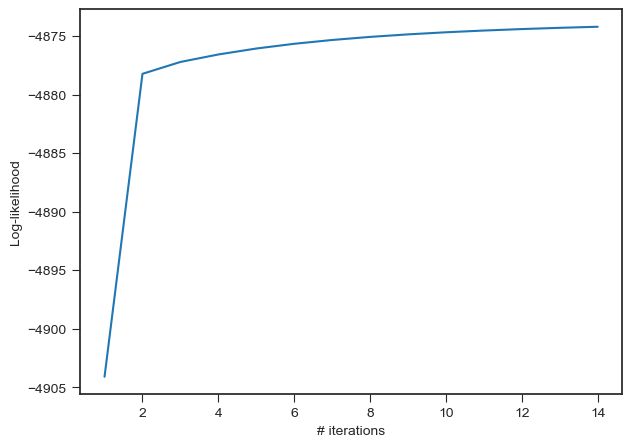

In [102]:
# generate observation sequences of different lengths
lengths = np.random.randint(25, 150, size=50)
X = [
    my_hmm.sample(n_sequences=1, n_samples=n_samples)[0] for n_samples in lengths
]

# instantiate a MultinomialHMM object
trained_hmm = MultinomialHMM(
    # number of hidden states (H and C)
    n_states=2,     
    # number of discrete emissions (how many ice creams Jason ate)
    n_emissions=1,
    # length of the observation alphabet (O = {1, 2, 3}, which becomes {0, 1, 2})
    n_features=[3],
    # prior for the start probabilities
    pi_prior=np.array([5, 1]),
    # type of initialisation to use; can be 'uniform' or 'random'
    init_type='random'
)

# reinitialise the parameters and see if we can re-learn them
trained_hmm, log_likelihoods = trained_hmm.train(
    X,
    n_init=1,     # no. of initialisations - we only do it once this time; if multiple initialisations are used, the model with the best log-likelihood will be returned
    n_iter=100,   # maximum no. of iterations to use
    conv_thresh=1e-04,   # convergence threshold (in this case if the change in consecutive log-likelihood is < 0.1%)
    conv_iter=10,  # no. of iterations for which the convergence criteria should hold before stopping
    plot_log_likelihood=True, # if we want a plot of the log-likelihood evolution over the iterations
)

Now if we look at the model parameters, we can see that using only 25 sequences of  25 - 150 samples leads to a quite accurate estimation of the parameters of the generator HMM. (Note that the order of states is swapped).

In [67]:
hu.pretty_print_hmm(my_hmm, states=states, emissions=observations)

Priors
+------------+------------+
|     H      |     C      |
+------------+------------+
| P(H)=0.800 | P(C)=0.200 |
+------------+------------+
Transitions
+---+--------------+--------------+
| _ |      H       |      C       |
+---+--------------+--------------+
| H | P(H|H)=0.600 | P(C|H)=0.400 |
| C | P(H|C)=0.500 | P(C|C)=0.500 |
+---+--------------+--------------+
Emissions
+---+--------------+--------------+--------------+
| _ |      1       |      2       |      3       |
+---+--------------+--------------+--------------+
| H | P(1|H)=0.200 | P(2|H)=0.400 | P(3|H)=0.400 |
| C | P(1|C)=0.500 | P(2|C)=0.400 | P(3|C)=0.100 |
+---+--------------+--------------+--------------+


In [100]:
hu.pretty_print_hmm(trained_hmm, states=states, emissions=observations)

Priors
+------------+------------+
|     H      |     C      |
+------------+------------+
| P(H)=0.547 | P(C)=0.453 |
+------------+------------+
Transitions
+---+--------------+--------------+
| _ |      H       |      C       |
+---+--------------+--------------+
| H | P(H|H)=0.436 | P(C|H)=0.564 |
| C | P(H|C)=0.464 | P(C|C)=0.536 |
+---+--------------+--------------+
Emissions
+---+--------------+--------------+--------------+
| _ |      1       |      2       |      3       |
+---+--------------+--------------+--------------+
| H | P(1|H)=0.409 | P(2|H)=0.137 | P(3|H)=0.455 |
| C | P(1|C)=0.277 | P(2|C)=0.588 | P(3|C)=0.135 |
+---+--------------+--------------+--------------+


# Gaussian HMM

Source of example: https://hmmlearn.readthedocs.io/en/0.2.0/auto_examples/plot_hmm_sampling.html#sphx-glr-auto-examples-plot-hmm-sampling-py. 

Consider an HMM with Gaussian emissions, 4 hidden states with specified mean and covariance. The following figure shows shows some samples drawn from the model with the corresponding transitions. 

<img src='img/gauss_hmm_samples.png' width='600'/>

## Differences Between Discrete HMM and Gaussian HMM

1. **Observation Type**  
   - **Discrete HMM**: Observations come from a **finite, discrete set** (e.g., \(\{1,2,3\}\), letters \(\{A,B,C,\dots\}\), etc.).  
     Each hidden state has a **categorical (multinomial) distribution** over these discrete symbols.
   - **Gaussian HMM**: Observations are **continuous** (real-valued).  
     Each hidden state is associated with a (multivariate) **Gaussian** distribution, characterized by a mean vector \(\boldsymbol{\mu}_s\) and a covariance matrix \(\Sigma_s\).

2. **Emission Parameterization**  
   - **Discrete HMM**: Stores a **probability table** for each state, such that
     \[
     P(o \mid s) = \theta_{s,o} \quad\text{(where \(o\) is a discrete symbol).}
     \]
   - **Gaussian HMM**: Stores **continuous distribution parameters** (mean and covariance) for each state, such that
     \[
     P(\mathbf{x} \mid s) 
     = \mathcal{N}(\mathbf{x}\,;\,\boldsymbol{\mu}_s, \Sigma_s).
     \]

3. **Use Cases**  
   - **Discrete HMM**: Natural for observations that are inherently discrete (e.g., word tokens, DNA nucleotides, or integer-coded events).  
   - **Gaussian HMM**: Common for **speech recognition**, **signal processing**, and other domains where observations are real-valued feature vectors (e.g., audio features, sensor measurements).

4. **Training and Inference**  
   - Both use similar **Forward–Backward** / **Baum–Welch** algorithms, but **emission probability** computations differ:
     - In a **discrete** HMM, you accumulate **symbol counts** during the E-step.
     - In a **Gaussian** HMM, you accumulate **sufficient statistics** (sums, sums of outer products) to update means and covariances in the M-step.
   - The **core HMM framework** (hidden states, transition probabilities, decoding with Viterbi, etc.) is identical; the difference lies in **how you model and compute** the emission probabilities (discrete vs. continuous).


## Setting up the model

The GaussianHMM class uses the following arguments for initialisation:

- *n_states* (int) - the number of hidden states
- *n_emissions* (int) - the number of distinct Gaussian observations
- *params* (string, optional) - controls which parameters are updated in the training process; defaults to all parameters
- *init_params* (string, optional) - controls which parameters are initialised prior to training; defaults to all parameters
- *init_type* (string, optional) - name of the initialisation method to use for initialising the model parameters before training; can be 'random' or 'kmeans'
- *covariance_type* (string, optional) - string describing the type of covariance parameters to use.  Must be one of: 'diagonal', 'full', 'spherical' or 'tied'; defaults to 'diagonal'
- *pi_prior* (array, optional) - array of shape (n_states, ) setting the parameters of the Dirichlet prior distribution for 'pi'
- *A_prior* (array, optional) - array of shape (n_states, n_states), giving the parameters of the Dirichlet prior distribution for each row of the transition probabilities 'A'
- *means_prior, means_weight* (array, optional) - arrays of shape (n_states, 1) providing the mean and precision of the Normal prior distribution for the means
- *covars_prior, covars_weight* (array, optional) - shape (n_states, 1), provides the parameters of the prior distribution for the covariance matrix
- *min_covar* (float, optional)- floor on the diagonal of the covariance matrix to prevent overfitting. Defaults to 1e-3.
- *learn_rate* (float, optional) - a value from the $[0,1)$ interval, controlling how much the past values of the model parameters count when computing the new model parameters during training; defaults to 0
- *verbose* (bool, optional) - flag to be set to True if per-iteration convergence reports should be printed during training


In [109]:
# instantiate a MultinomialHMM object
my_hmm = GaussianHMM(
    n_states=4,
    n_emissions=2,
    covariance_type='diagonal'
)

# we set model parameters according to the example
# the initial state probabilities, array of shape (n_states, )
my_hmm.pi = np.array([0.6, 0.3, 0.1, 0.0])
# the state transition probabilities, array of shape (n_states, n_states)
my_hmm.A = np.array(
    [
        [0.7, 0.2, 0.0, 0.1],
        [0.3, 0.5, 0.2, 0.0],
        [0.0, 0.3, 0.5, 0.2],
        [0.2, 0.0, 0.2, 0.6],
    ]
)
# the means of each component
my_hmm.means = np.array([[0.0, 0.0], [0.0, 11.0], [9.0, 10.0], [11.0, -1.0]])

# the covariance of each component - shape depends `covariance_type`
#             (n_states, )                          if 'spherical',
#             (n_states, n_emissions)               if 'diagonal',
#             (n_states, n_emissions, n_emissions)  if 'full'
#             (n_emissions, n_emissions)            if 'tied'
my_hmm.covars = 0.5 * np.ones((4, 2))  # diagonal covariance matrix

hu.pretty_print_hmm(my_hmm, hmm_type='Gaussian')

Priors
+--------------+--------------+--------------+--------------+
|     S_0      |     S_1      |     S_2      |     S_3      |
+--------------+--------------+--------------+--------------+
| P(S_0)=0.600 | P(S_1)=0.300 | P(S_2)=0.100 | P(S_3)=0.000 |
+--------------+--------------+--------------+--------------+
Transitions
+-----+------------------+------------------+------------------+------------------+
|  _  |       S_0        |       S_1        |       S_2        |       S_3        |
+-----+------------------+------------------+------------------+------------------+
| S_0 | P(S_0|S_0)=0.700 | P(S_1|S_0)=0.200 | P(S_2|S_0)=0.000 | P(S_3|S_0)=0.100 |
| S_1 | P(S_0|S_1)=0.300 | P(S_1|S_1)=0.500 | P(S_2|S_1)=0.200 | P(S_3|S_1)=0.000 |
| S_2 | P(S_0|S_2)=0.000 | P(S_1|S_2)=0.300 | P(S_2|S_2)=0.500 | P(S_3|S_2)=0.200 |
| S_3 | P(S_0|S_3)=0.200 | P(S_1|S_3)=0.000 | P(S_2|S_3)=0.200 | P(S_3|S_3)=0.600 |
+-----+------------------+------------------+------------------+------------------+

## Problem 3

For this task, similarly like in the discrete HMM case, we first generate some observation sequences from the model, after we will create a model, in which the parameters are initialised randomly and try to learn the generator's parameters from the observation sequences.

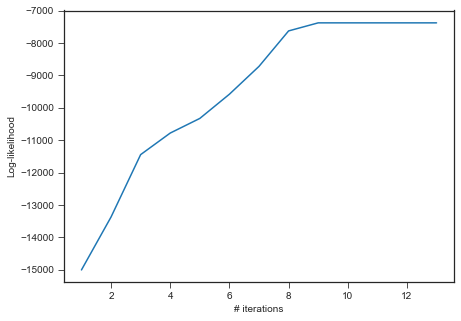

In [8]:
# generate observation sequences of different lengths
lengths = np.random.randint(25, 150, size=25)
X = [
    my_hmm.sample(n_sequences=1, n_samples=n_samples)[0] for n_samples in lengths
]

# instantiate a MultinomialHMM object
trained_hmm = GaussianHMM(
    # number of hidden states
    n_states=4,
    # number of distinct emissions
    n_emissions=2,
    # can be 'diagonal', 'full', 'spherical', 'tied'
    covariance_type='diagonal',
    verbose=False
)

# reinitialise the parameters and see if we can re-learn them
trained_hmm, log_likelihoods = trained_hmm.train(
    X,
    n_init=1,     # number of initialisations to perform
    n_iter=100,   # maximum number of iterations to run
    conv_thresh=0.001,  # what percentage of change in the log-likelihood between iterations is considered convergence
    conv_iter=5,  # for how many iterations does it have to hold
    # whether to plot the evolution of the log-likelihood over the iterations
    plot_log_likelihood=True,
    # set to True if want to train until maximum number of iterations is reached
    ignore_conv_crit=False,
    no_init=False,  # set to True if the model parameters shouldn't be re-initialised befor training; in this case they have to be set manually first, otherwise errors occur
)

Now if we look at the model parameters, we can see that using only 25 sequences of  25 - 150 samples leads to a quite accurate estimation of the parameters of the generator HMM. (Note that the order of states is swapped).

In [9]:
hu.pretty_print_hmm(trained_hmm, hmm_type='Gaussian')

Priors
+--------------+--------------+--------------+--------------+
|     S_0      |     S_1      |     S_2      |     S_3      |
+--------------+--------------+--------------+--------------+
| P(S_0)=0.480 | P(S_1)=0.320 | P(S_2)=0.200 | P(S_3)=0.000 |
+--------------+--------------+--------------+--------------+
Transitions
+-----+------------------+------------------+------------------+------------------+
|  _  |       S_0        |       S_1        |       S_2        |       S_3        |
+-----+------------------+------------------+------------------+------------------+
| S_0 | P(S_0|S_0)=0.647 | P(S_1|S_0)=0.199 | P(S_2|S_0)=0.026 | P(S_3|S_0)=0.127 |
| S_1 | P(S_0|S_1)=0.303 | P(S_1|S_1)=0.448 | P(S_2|S_1)=0.213 | P(S_3|S_1)=0.036 |
| S_2 | P(S_0|S_2)=0.050 | P(S_1|S_2)=0.336 | P(S_2|S_2)=0.439 | P(S_3|S_2)=0.175 |
| S_3 | P(S_0|S_3)=0.192 | P(S_1|S_3)=0.045 | P(S_2|S_3)=0.185 | P(S_3|S_3)=0.578 |
+-----+------------------+------------------+------------------+------------------+

# HMM with labels

## Loading the training data

The Heterogeneous HMM or HMM with labels is helpful when we desire to use an Hidden Markov Model but we want to have different types of distributions managing each of the possible observations.

To illustrate this case, we are gonna train an HMM to manage the activity level of an user (a simple HAR problem) by using data collected from his smartphone. Four different types of data are going to be used during training and prediction:

- Actigraphy data: it is a continuous signal (it is computed by integrating the three axes of the acceleromenter) that represents the movement of the smartphone.

- Light data: it is also a continous signal that represent the ambient light (it is obtainned from the light sensor of the smartphone).

- App usage data: this is a binary signal that represent if the user is using (1) or not (0) the smartphone.

- Fitbit sleep data: this is also a binary signal, where the 1 represent that the fitbit wearable reports that the user is sleep and 0 that he/she is not.

To train the model we have sequences of 24 hours where, at every time instant, we have three different features/observations: the actigraphy, the light and the app usage data points. **It is important to understand that the model, throught the EM algorithm, supports partial or complete missing data**, which means that some of the features or all of them could be missing data points.

*An example of one of the sequences used to train the data can be seen in the next image*: it can be seen that, for the light sensor, most of the data is not available, which will be managed by the model thanks to the missing data support.

<img src='img/heterogeneous_samples.png' width='600'/>

Given the nature of this data, we will use gaussians to manage the actigraphy and light signals and a binary distribution to manage the app usage (if the data had more than two categories, a categorical distribution could be used).

With all this data we are going to train a simple Heterogeneous-HMM (where the labels are the app usage and fitbit data) with two states.


In [112]:
# load the training data - train.pickle contains a dataframe of 10 time series sequences of 286 - 289 observations
# and the preprocessed training sequence list as well
with open('data/train.pickle', 'rb') as f:
    temp = pickle.load(open('data/train.pickle', 'rb'))
    df = temp['all']
    training_seq = temp['tr_seq']
    
df.head()

,seq_no,date,actigraphy,light,app_usage,sleep
0,0,2018-08-05 15:05:30,-0.305134,-0.918191,1,0
1,0,2018-08-05 15:10:32,-0.290736,NaN,1,0
2,0,2018-08-05 15:15:32,-0.595398,NaN,1,0
3,0,2018-08-05 15:20:34,-0.545724,NaN,1,0
4,0,2018-08-05 15:25:34,0.033796,NaN,1,0


## Training the model

The HeterogeneousHMM class uses the following arguments for initialisation:
- *n_states* (int) - the number of hidden states.
- *n_g_emissions* (int) - the number of distinct Gaussian observations.
- *n_d_emissions* (int) - the number of distinct discrete observations.
- *n_d_features* (list - list of the number of possible observable symbols for each discrete emission.
- *params* (string, optional) - controls which parameters are updated in the training process; defaults to all parameters.
- *init_params* (string, optional) - controls which parameters are initialised prior to training; defaults to all parameters.
- *init_type* (string, optional) - name of the initialisation method to use for initialising the model parameters before training; can be 'random' or 'kmeans'.
- *nr_no_train_de* (int) - this number indicates the number of discrete emissions whose Matrix Emission Probabilities are fixed and are not trained; it is important to to order the observed variables such that the ones whose emissions aren't trained are the last ones. 
- *state_no_train_de* (int) - a state index for nr_no_train_de which shouldn't be updated; defaults to None, which means that the entire emission probability matrix for that discrete emission will be kept unchanged during training, otherwise the last state_no_train_de states won't be updated
- *covariance_type* (string, optional) - string describing the type of covariance parameters to use.  Must be one of: 'diagonal', 'full', 'spherical' or 'tied'; defaults to 'diagonal'.
- *pi_prior* (array, optional) - array of shape (n_states, ) setting the parameters of the Dirichlet prior distribution for 'pi'.
- *A_prior* (array, optional) - array of shape (n_states, n_states), giving the parameters of the Dirichlet prior distribution for each row of the transition probabilities 'A'.
- *means_prior, means_weight* (array, optional) - arrays of shape (n_states, 1) providing the mean and precision of the Normal prior distribution for the means.
- *covars_prior, covars_weight* (array, optional) - shape (n_states, 1), provides the parameters of the prior distribution for the covariance matrix.
- *min_covar* (float, optional)- floor on the diagonal of the covariance matrix to prevent overfitting. Defaults to 1e-3.
- *learn_rate* (float, optional) - a value from the $[0,1)$ interval, controlling how much the past values of the model parameters count when computing the new model parameters during training; defaults to 0.
- *verbose* (bool, optional) - flag to be set to True if per-iteration convergence reports should be printed during training.


We create a model that will have 2 states (just to keep it simple), that will managed 2 features with gaussian distributions and 2 features as discrete observations. With the 'n_d_features' parameter we indicate the model that the two features that we want to manage as discrete are both binary. If, for example, the app usage could take three different values, the 'n_d_features' would be equal to [3,2].

**The model also allows us to fix some of the discrete observations probabilities**: for example, if we want one of the states not to be reachable when the fitbit is equal to 1 (which means that the user is sleeping according to fitbit's data), we can fix the emission probability for one of the states to 1 when fitbit=1 and to 0 in the other case, **we do this  in the next section of code by accesing to my_hmm.B**. *Also, to indicate the model that we want it to not train this last feature, we set 'nr_no_train_de=1'* **(the last 'nr_no_train_de' are not trained but fixed to the original value)**. In case we don´t desire the model to fix certain probabilities of emission, 'nr_no_train_de' must be equal to zero, which means that the model will train all the emission probabilities.

Initialisation 1


C:\Users\Jiyan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


iter: 0, log_likelihood = -11427.374576011112, delta = nan
iter: 1, log_likelihood = -6716.942364817294, delta = 4710.432211193818
iter: 2, log_likelihood = -5780.38725261105, delta = 936.5551122062443
iter: 3, log_likelihood = -5663.7164725437515, delta = 116.67078006729844
iter: 4, log_likelihood = -5612.541430534461, delta = 51.17504200929034
iter: 5, log_likelihood = -5577.0475999550845, delta = 35.49383057937666
iter: 6, log_likelihood = -5551.443246734843, delta = 25.604353220241137
iter: 7, log_likelihood = -5532.753374220423, delta = 18.68987251442013
iter: 8, log_likelihood = -5518.939810061301, delta = 13.813564159122507
iter: 9, log_likelihood = -5508.559681273193, delta = 10.380128788107868
iter: 10, log_likelihood = -5500.59733559445, delta = 7.962345678743077
iter: 11, log_likelihood = -5494.345159114941, delta = 6.252176479508307
iter: 12, log_likelihood = -5489.312982229734, delta = 5.032176885207264
iter: 13, log_likelihood = -5485.160362872391, delta = 4.1526193573436

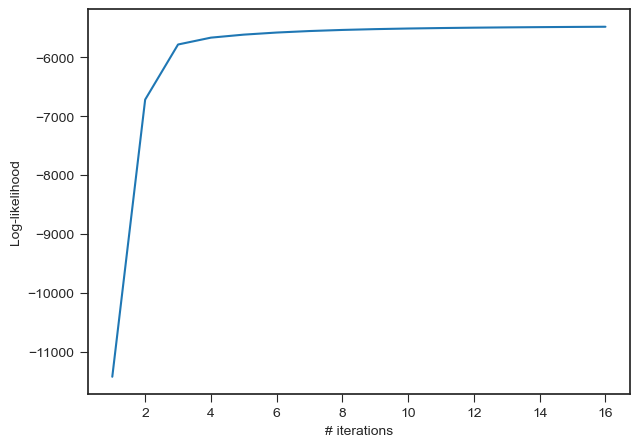

Initialisation 2


C:\Users\Jiyan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


iter: 0, log_likelihood = -11350.802830816783, delta = nan
iter: 1, log_likelihood = -6585.809247325842, delta = 4764.993583490941
iter: 2, log_likelihood = -5773.429608633029, delta = 812.3796386928134
iter: 3, log_likelihood = -5662.572046349546, delta = 110.85756228348237
iter: 4, log_likelihood = -5613.034455333326, delta = 49.537591016220176
iter: 5, log_likelihood = -5578.125428168257, delta = 34.90902716506935
iter: 6, log_likelihood = -5552.852007163351, delta = 25.273421004905686
iter: 7, log_likelihood = -5534.373813555863, delta = 18.47819360748781
iter: 8, log_likelihood = -5520.696576459899, delta = 13.677237095964301
iter: 9, log_likelihood = -5510.400721931015, delta = 10.295854528883865
iter: 10, log_likelihood = -5502.485353236462, delta = 7.915368694552853
iter: 11, log_likelihood = -5496.252399454293, delta = 6.232953782169716
iter: 12, log_likelihood = -5491.218224605298, delta = 5.034174848994553
iter: 13, log_likelihood = -5487.047551690195, delta = 4.170672915102

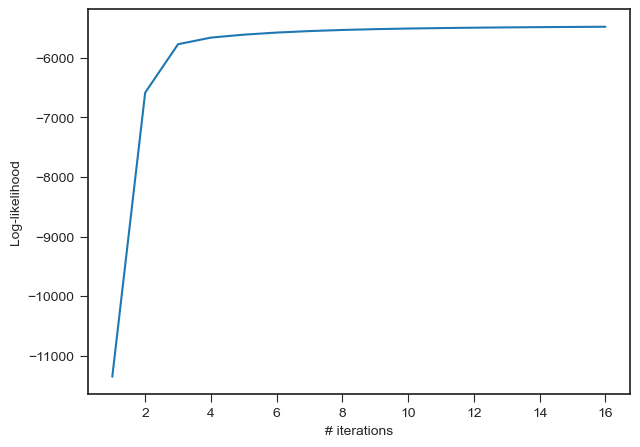

Initialisation 3


C:\Users\Jiyan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


iter: 0, log_likelihood = -12242.265553565809, delta = nan
iter: 1, log_likelihood = -6278.20710152069, delta = 5964.058452045118
iter: 2, log_likelihood = -5737.532738421583, delta = 540.6743630991068
iter: 3, log_likelihood = -5662.112452906983, delta = 75.42028551460044
iter: 4, log_likelihood = -5614.514450768412, delta = 47.598002138571246
iter: 5, log_likelihood = -5579.84576386265, delta = 34.668686905762115
iter: 6, log_likelihood = -5554.577649546087, delta = 25.268114316562787
iter: 7, log_likelihood = -5536.065829011973, delta = 18.511820534114122
iter: 8, log_likelihood = -5522.350797296067, delta = 13.715031715905752
iter: 9, log_likelihood = -5512.018625332009, delta = 10.332171964058034
iter: 10, log_likelihood = -5504.068309653723, delta = 7.950315678285733
iter: 11, log_likelihood = -5497.800481986125, delta = 6.267827667597885
iter: 12, log_likelihood = -5492.730297028562, delta = 5.07018495756347
iter: 13, log_likelihood = -5488.521941872903, delta = 4.20835515565886

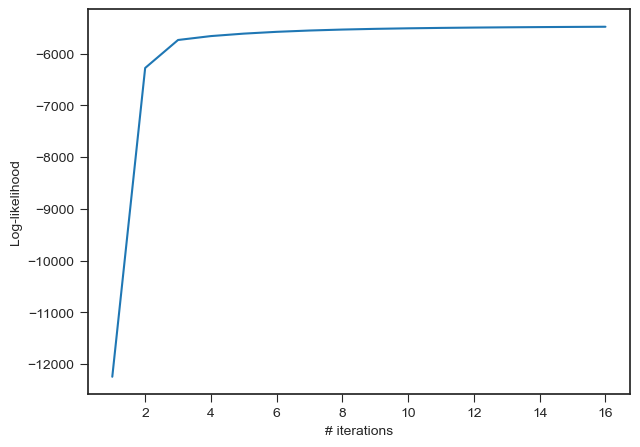

Priors
+--------------+--------------+
|     S_0      |     S_1      |
+--------------+--------------+
| P(S_0)=0.815 | P(S_1)=0.185 |
+--------------+--------------+
Transitions
+-----+------------------+------------------+
|  _  |       S_0        |       S_1        |
+-----+------------------+------------------+
| S_0 | P(S_0|S_0)=0.955 | P(S_1|S_0)=0.045 |
| S_1 | P(S_0|S_1)=0.061 | P(S_1|S_1)=0.939 |
+-----+------------------+------------------+
Means
+-----+--------+--------+
|  _  |  GE_0  |  GE_1  |
+-----+--------+--------+
| S_0 | 0.331  | -0.113 |
| S_1 | -0.456 | 0.909  |
+-----+--------+--------+
Covariances
S_0
+------+-------+-------+
|  _   |  GE_0 |  GE_1 |
+------+-------+-------+
| GE_0 | 1.359 | 0.000 |
| GE_1 | 0.000 | 0.176 |
+------+-------+-------+
S_1
+------+-------+-------+
|  _   |  GE_0 |  GE_1 |
+------+-------+-------+
| GE_0 | 0.147 | 0.000 |
| GE_1 | 0.000 | 0.016 |
+------+-------+-------+
Emissions
+-----+--------------------+--------------------+
|  

In [114]:
# instantiate a HeterogeneousHMM object
my_hmm = HeterogeneousHMM(
        n_states=2,
        n_g_emissions=2,
        n_d_emissions=2,
        n_d_features=[2, 2],
        covariance_type='diagonal',
        nr_no_train_de=1,
        verbose=True,
    )

# we want to fix the emission probabilities for the sleep parameter, so we need to manually initialise the 
# B matrix before the fitting; so for the first emissions, since we have no prior knowledge on it, we uniformly
# initialise the emission probablities, and for the second one we set it to the desired value
my_hmm.B = [0.5*np.ones((2,2)), np.eye(2)]

# train the model to estimate the parameters
my_hmm, log_likelihood = my_hmm.train(
    training_seq, n_init=3, n_iter=50, conv_thresh=0.001, conv_iter=5, plot_log_likelihood=True,
)

# print model parameters
hu.pretty_print_hmm(my_hmm, hmm_type='Heterogeneous')

As you can see in the previous table, the emission proabilities of the second discrete feature (fitbit data) has been fixed to 0 and 1 values during the training as we indicate with the 'nr_no_train_de' variable during initialization. **It is also possible to partially training the emission probabilities to let the model train the probabilities for certain states while fixing those probability values for the rest of the states**, to do so, the variable **'state_no_train_de'** must be used.

## Sequence decoding

/Users/esukei/opt/miniconda3/envs/hmm_env/lib/python3.7/site-packages/pyhhmm/utils.py:463: UserWarning: FixedFormatter should only be used together with FixedLocator
  for ts in time_stamps])
/Users/esukei/opt/miniconda3/envs/hmm_env/lib/python3.7/site-packages/pyhhmm/utils.py:463: UserWarning: FixedFormatter should only be used together with FixedLocator
  for ts in time_stamps])
/Users/esukei/opt/miniconda3/envs/hmm_env/lib/python3.7/site-packages/pyhhmm/utils.py:463: UserWarning: FixedFormatter should only be used together with FixedLocator
  for ts in time_stamps])
/Users/esukei/opt/miniconda3/envs/hmm_env/lib/python3.7/site-packages/pyhhmm/utils.py:463: UserWarning: FixedFormatter should only be used together with FixedLocator
  for ts in time_stamps])


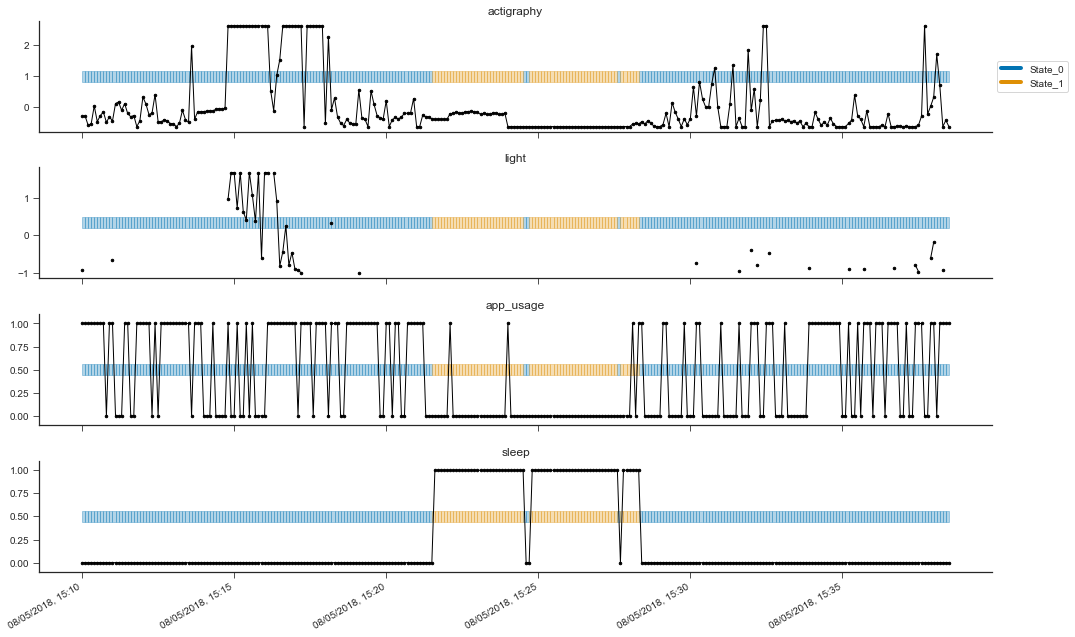

In [12]:
# decode a training sequences
logL, state_seq = my_hmm.decode([training_seq[0]], algorithm='viterbi')

hu.plot_decode(
    training_seq[0], 
    ['actigraphy', 'light', 'app_usage', 'sleep'], 
    state_seq[0], 
    discrete_columns=['app_usage', 'sleep'], 
    time_stamps=df[df['seq_no'] == 0]['date'],
    figsize=(15, 10)
)
               

In the previous figure we can observe that the model has clearly associated the state 1 to being sleep because we fixed the emission probabilities to p(state_1 | being_sleep)=1 and p(state_1 | being_awake)=0. This way, we get the model to train the rest of the parameters in order to that state to represent the sleep of the users. If we hadn´t fix those probabilities, the emission probability matrix of both of the state for the sleep feature would have been trained from scratch.